In [193]:
import configparser
from pathlib import Path
import pandas as pd
import pandas.io.sql as pandasql
from psycopg2 import connect
import numpy
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from setuptools import setup, find_packages
import matplotlib.patches as patches
CONFIG = configparser.ConfigParser()
CONFIG.read(str(Path.home().joinpath('db.cfg')))
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [190]:
routed = pd.read_sql('''select * from congestion.agg_test''',con)

In [186]:
def handle_subsection(subsection, prev_i, max_segment_length=300.):
    # Scans through each subsection of `lengths`, grouping together
    # segments up to `max_segment_length`.
    subsec_segments = [{'idx': [prev_i, ], 'length': subsection[0]}]

    if len(subsection) > 1:
        for i, item in enumerate(subsection[1:]):
            if subsec_segments[-1]['length'] + item > max_segment_length:
                subsec_segments.append({'idx': [i + prev_i + 1, ], 'length': item})
            else:
                subsec_segments[-1]['idx'].append(i + prev_i + 1)
                subsec_segments[-1]['length'] += item

    return subsec_segments

In [191]:
max_multi_length = 300.
min_segment_length = 150.
for index, row in routed.iterrows():
    segment_id = routed['segment_id'].iloc[index].astype(float)
    lengths = routed['length_set'].iloc[index]
    link_dir = routed['link_set'].iloc[index]    
    segments = []

    prev_i = 0
    for i, item in enumerate(lengths):
        if item > max_multi_length:
            # Extract all lengths larger than `max_multi_length`.  These will be single-link segments.
            segments.append({'idx': [i, ], 'length': item})
            # Handle the subsections between large links using the functiona bove.
            if prev_i !=0:
                segments.extend(handle_subsection(lengths[prev_i:i], prev_i, max_segment_length=max_multi_length))
                prev_i = i + 1
    # Handle subsection after last large link.
    segments.extend(handle_subsection(lengths[prev_i:], prev_i))
    # Sort according to first index in each subsection.
    segments = sorted(segments, key=lambda x: x['idx'][0])
    too_small = [i for i in range(len(segments)) if segments[i]['length'] < min_segment_length]
    
    # Handle deleting subsections that are too small.
    n_deleted = 0
    for ir in too_small:
        i = ir - n_deleted
        if i == 0:
            segments[1]['idx'] = segments[i]['idx'] + segments[1]['idx']
            segments[1]['length'] += segments[i]['length']
        elif i == len(segments) - 1:
            segments[-2]['idx'] += segments[i]['idx']
            segments[-2]['length'] += segments[i]['length']
        else:
            if segments[i - 1]['length'] >= segments[i + 1]['length']:
                segments[i + 1]['idx'] = segments[i]['idx'] + segments[i + 1]['idx']
                segments[i + 1]['length'] += segments[i]['length']
            else:
                segments[i - 1]['idx'] += segments[i]['idx']
                segments[i - 1]['length'] += segments[i]['length']
        del segments[i]
        n_deleted += 1

    rows = []
    for i in range(len(segments)):
        id = i
        new_length = segments[i]['length']
        link_set = []
        for i in segments[i]['idx']:
            link_set.append(link_dir[i])
        #insert to postgres
        row = (segment_id, id, link_set, new_length)
        rows.append(row)

    sql = '''insert into congestion.test_pythonmerge(segment_id, id, link_set, length) VALUES %s'''    
    with con:
        with con.cursor() as cur:
            execute_values(cur, sql, rows)     

In [187]:
segment_id = routed['segment_id'].iloc[8].astype(float)
lengths = routed['length_set'].iloc[8]
link_dir = routed['link_set'].iloc[8]    
max_multi_length = 300.
min_segment_length = 150.
segments = []

prev_i = 0
for i, item in enumerate(lengths):
    if item > max_multi_length:
        # Extract all lengths larger than `max_multi_length`.  These will be single-link segments.
        segments.append({'idx': [i, ], 'length': item})
        # Handle the subsections between large links using the function above.
        if prev_i !=0:
            segments.extend(handle_subsection(lengths[prev_i:i], prev_i, max_segment_length=max_multi_length))
            prev_i = i + 1
        
# Handle subsection after last large link.
segments.extend(handle_subsection(lengths[prev_i:], prev_i))
# Sort according to first index in each subsection.
segments = sorted(segments, key=lambda x: x['idx'][0])
too_small = [i for i in range(len(segments)) if segments[i]['length'] < min_segment_length]

# Handle deleting subsections that are too small.
n_deleted = 0
for ir in too_small:
    i = ir - n_deleted
    if i == 0:
        segments[1]['idx'] = segments[i]['idx'] + segments[1]['idx']
        segments[1]['length'] += segments[i]['length']
    elif i == len(segments) - 1:
        segments[-2]['idx'] += segments[i]['idx']
        segments[-2]['length'] += segments[i]['length']
    else:
        if segments[i - 1]['length'] >= segments[i + 1]['length']:
            segments[i + 1]['idx'] = segments[i]['idx'] + segments[i + 1]['idx']
            segments[i + 1]['length'] += segments[i]['length']
        else:
            segments[i - 1]['idx'] += segments[i]['idx']
            segments[i - 1]['length'] += segments[i]['length']
    del segments[i]
    n_deleted += 1
segments

[{'idx': [0], 'length': 326.430064591479},
 {'idx': [0, 1, 2], 'length': 457.39379958515735}]

In [169]:

rows = []
for i in range(len(segments)):
    id = i
    link_set = []
    for i in segments[i]['idx']:
        link_set.append(link_dir[i])
    #insert to postgres
    row = (segment_id, id, link_set)
    rows.append(row)
    
print(rows)


<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
[(7.0, 0, ['1213990864F', '1213990865F']), (7.0, 1, ['993160758F']), (7.0, 2, ['783070658F', '799812691F']), (7.0, 3, ['1192713549F', '1192713550F', '892031169F']), (7.0, 4, ['892031170F', '822376672F', '799812693F'])]


In [164]:
rows = []
for i in range(len(segments)):
    id = i
    print(type(segment_id))
    link_set = []
    for i in segments[i]['idx']:
        link_set.append(link_dir[i])
    #insert to postgres
    row = (segment_id, id, link_set)
    rows.append(row)
    
print(rows)
sql = '''insert into congestion.test_pythonmerge(segment_id, id, link_set) VALUES %s'''    
with con:
    with con.cursor() as cur:
        execute_values(cur, sql, rows) 

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
[(7.0, 0, ['1213990864F', '1213990865F', '993160758F']), (7.0, 1, ['783070658F', '799812691F']), (7.0, 2, ['1192713549F', '1192713550F', '892031169F']), (7.0, 3, ['892031170F', '822376672F', '799812693F'])]


Text(0, 0.5, 'Frequency')

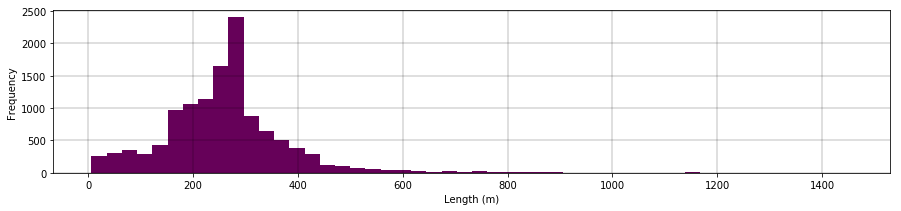

In [197]:
class colour:
    """
    Class defining the global colour variables for all functions.
    
    """
    purple = '#660159'
    grey = '#7f7e7e'
    light_grey = '#777777'
    cmap = 'YlOrRd'
duration_freq = pd.read_sql('''select length from congestion.pythonmerge_results''',con)
plt.figure(figsize=(15,3))
plt.hist(duration_freq.length, bins=50, color = colour.purple)
axes = plt.gca()
axes.set_facecolor('xkcd:white')
axes.grid(color='k', linestyle='-', linewidth=0.25)
#plt.xlim((0,200))
plt.xlabel('Length (m)')
plt.ylabel('Frequency')